# Schritt 1: Vorbereitung

Im folgenden werden allgemeine Funktionen definiert, die flexibel und modell- sowie datensatzunabhängig sind. Diese Funktionen sind so konzipiert, dass sie auf verschiedene Modelle und Datensätze angewendet werden können, ohne dass spezifische Anpassungen für jedes Modell oder jeden Datensatz vorgenommen werden müssen.

## Pakete importieren

In [39]:
%pip install --upgrade pip setuptools wheel
%pip install liac-arff
%pip install tslearn
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install tensorflow
%pip install tqdm
%pip install tslearn.neighbors
%pip install matplotlib
%pip install scipy
%pip install pyts


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tslearn.neighbors (from versions: none)
ERROR: No matching distribution found for tslearn.neighbors


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.spatial import distance
from pyts.transformation import ShapeletTransform
from sklearn.metrics import accuracy_score
from tslearn.utils import to_sklearn_dataset
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from tslearn.datasets import UCR_UEA_datasets

## Datensatz laden

In [41]:
# Funktion zum Laden der Daten über tslearn und Reshaping der Dimensionen
def read_data(DS):
    # Lade den Datensatz über die tslearn-Bibliothek
    ucr = UCR_UEA_datasets()
    X_train, y_train, X_test, y_test = ucr.load_dataset(DS)
    
    # Überprüfe, ob die Eingabedaten mehrdimensional sind (z.B. 3D) und flache sie auf 2D ab
    if X_train.ndim == 3:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    if X_test.ndim == 3:
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    
    # Wandle die Labels in Integer-Klassen um
    y_train, y_test = label_encoder(y_train, y_test)
    return X_train, X_test, y_train, y_test



## Datenvorbereitung

Die Funktion label_encoder wird verwendet, um die Labels der Trainings- und Testdaten in Ganzzahlen (Integer) zu kodieren.

Gründe:
- Maschinenlernalgorithmen arbeiten mit numerischen Werten (Datensätze mit Text oder Kategorien werden umgewandlet)
- Um sicherzustellen, dass die gleichen Kategorien in den Trainings- und Testdaten gleich behandelt werden, wird der LabelEncoder auf die kombinierten Trainings- und Testdaten angepasst. Dadurch werden alle Kategorien erkannt und entsprechend kodiert

In [42]:
# Funktion zum Kodieren der Labels als Ganzzahlen
def label_encoder(training_labels, testing_labels):
    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)
    return y_train, y_test

## Muster identifizieren

Die Kombination der beiden folgenden Funktionen erlaubt es, aus Zeitreihen charakteristische Muster zu extrahieren, die spezifisch für bestimmte Klassen sind, was für die Klassifikation nützlich ist.

Diese Funktion ist für die Extraktion von Shapelets aus den Trainingsdaten verantwortlich. Shapelets sind kurze, charakteristische Muster, die in den Zeitreihen vorkommen und zur Klassifikation verwendet werden können

Initialisierung des Shapelet-Transformationsmodells:

Das Modell ShapeletTransform wird erstellt. Die wichtigsten Parameter sind:
n_shapelets=100: Extrahiere 100 Shapelets aus den Zeitreihen.
window_sizes=[a, b, c]: Verwende die zuvor berechneten Fenstergrößen, um Shapelets verschiedener Längen zu extrahieren.
random_state=42: Dies sorgt dafür, dass die zufällige Auswahl von Shapelets in verschiedenen Läufen des Codes gleich bleibt (Reproduzierbarkeit).
sort=True: Sortiere die extrahierten Shapelets nach ihrer Wichtigkeit

Anpassung und Transformation des Modells:

st.fit_transform(X_train, y_train) passt das Shapelet-Transformationsmodell an die Trainingsdaten an.
Es analysiert die Zeitreihen X_train und die zugehörigen Labels y_train, um 100 Shapelets zu extrahieren, die am besten zwischen den Klassen unterscheiden.

Extraktion der Shapelet-Indizes:

Nachdem das Shapelet-Transformationsmodell angepasst wurde, werden die Indizes der extrahierten Shapelets gespeichert. Diese Indizes enthalten Informationen darüber, an welcher Position jedes Shapelet in den ursprünglichen Zeitreihen gefunden wurde.
Diese Indizes werden in einem pandas.DataFrame gespeichert und zurückgegeben.

--> Diese Funktion extrahiert Shapelets, die charakteristische Muster in den Zeitreihen darstellen und zur Klassifikation verwendet werden können. Sie passt ein Shapelet-Transformationsmodell an und gibt die Indizes der extrahierten Shapelets zurück.

In [43]:
import tslearn
import pandas as pd

def get_shapelet(X_train, y_train, len_ts):
    # Define window sizes for shapelets
    a = int(len_ts * 0.3)
    b = int(len_ts * 0.5)
    c = int(len_ts * 0.7)
    
    # Initialize ShapeletTransform
    st = ShapeletTransform(n_shapelets=100, window_sizes=[a, b, c], random_state=42, sort=True)
    
    # Fit and transform the data
    X_transformed = st.fit_transform(X_train, y_train)
    
    # Extract indices of shapelets
    indices = pd.DataFrame(st.indices_)
    
    return indices


Diese Funktion kategorisiert die extrahierten Shapelets basierend auf ihren zugehörigen Klassenlabels. Sie filtert die Shapelets für eine bestimmte Klasse heraus.

Schritt-für-Schritt-Erklärung:
Extraktion der Labels der Shapelets:

Die Funktion verwendet die Indizes der Shapelets, um die zugehörigen Klassenlabels aus y_train zu extrahieren.
indices.iloc[:, 0] liefert die Indizes der Zeitreihen, aus denen die Shapelets extrahiert wurden. Diese Indizes werden verwendet, um die zugehörigen Labels aus y_train zu erhalten.

Erstellen eines DataFrames für die Labels:

Die extrahierten Labels werden in ein pandas.DataFrame konvertiert, damit sie später mit den Shapelet-Indizes kombiniert werden können.

Kombinieren der Shapelet-Indizes und Labels:

Die Shapelet-Indizes und die zugehörigen Labels werden zu einem einzigen DataFrame zusammengeführt.
Dieser DataFrame hat vier Spalten:
- idx: Index der Zeitreihe, aus der das Shapelet stammt.
- start_point: Startpunkt des Shapelets in der Zeitreihe.
- end_point: Endpunkt des Shapelets in der Zeitreihe.
- label: Klassenlabel des Shapelets.

Gruppieren nach Labels:

Der DataFrame wird nach dem Klassenlabel gruppiert. Dies ist nützlich, um Shapelets zu filtern, die zu einer bestimmten Klasse gehören.

Filtern der Shapelets für eine bestimmte Klasse:

Die Funktion filtert die Shapelets für die angegebene Klasse label. Sie gibt die ersten Shapelets zurück, die zu dieser Klasse gehören.

Konvertieren des Ergebnisses in ein NumPy-Array:

Schließlich wird das Ergebnis in ein NumPy-Array umgewandelt, um es einfacher weiterverarbeiten zu können.

--> Diese Funktion kategorisiert die extrahierten Shapelets basierend auf den Klassenlabels der Trainingsdaten. Sie filtert die Shapelets für eine bestimmte Klasse heraus und gibt die relevanten Shapelets zurück.

In [44]:
# Funktion zur Kategorisierung der Shapelets basierend auf den Labels
def shapelet_category(y_train, indices, label):
    labels = y_train[indices.iloc[:, 0]]
    labels = pd.DataFrame(labels)
    frames = [indices, labels]
    res = pd.concat(frames, axis=1)
    res.columns = ["idx", "start_point", "end_point", "label"]
    res = res.groupby('label')
    res = res.get_group(label).head(1)
    res = np.array(res)
    return res

In [45]:
# Funktion zum Plotten der Shapelets
def plot_shapelet(X_train, shapelets, cls, save_path=None):
    plt.style.use('bmh')
    
    # Plot der gesamten Zeitreihe und des Shapelets
    plt.plot(X_train[shapelets[cls][0][0]], )
    plt.plot(np.arange(shapelets[cls][0][1], shapelets[cls][0][2]),
             X_train[shapelets[cls][0][0], shapelets[cls][0][1]:shapelets[cls][0][2]], label="shapelet")
    plt.xlabel('Time', fontsize=12)
    plt.title('The shapelets for class ' + str(cls), fontsize=14)
    plt.legend()
    
    # Speichere das Diagramm oder zeige es an
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

## Modell

Training eines beliebigen Modells.

- Das Modell wird durch die Funktion train_model() trainiert. Das spezifische Modell wird durch den Parameter classifier bestimmt. Es könnte ein beliebiges Machine-Learning-Modell sein, das in Scikit-learn verwendet werden kann (z.B. Random Forest, SVM, etc.).
- Die Funktion target() zielt darauf ab, die zweitwahrscheinlichste Klasse zu bestimmen.
- targets_generation() verwendet die zweitwahrscheinlichste Klasse als Ziel.
- eval_model() berechnet die Genauigkeit des Modells auf den Testdaten.

Der Code gibt dir die Flexibilität, verschiedene Klassifikatoren zu verwenden und unterschiedliche Ziele zu betrachten (wie z.B. die zweitwahrscheinlichste Klasse).

Trainieren des Modells:
- Die Funktion train_model(classifier, X_train, y_train, X_test) nimmt einen vorkonfigurierten Klassifikator (classifier) als Eingabe entgegen.
- Das Modell wird mit den Daten (X_train, y_train) trainiert, indem die Methode fit() aufgerufen wird.
- Da der Klassifikator als Parameter übergeben wird, kann es sich um beliebige Modelle handeln, die mit fit() trainiert werden können, z.B. RandomForestClassifier, SVC, KNeighborsClassifier, usw.

In [46]:
# Funktion zum Trainieren des Klassifikators
#def train_model(classifier, X_train, y_train, X_test):
#    model = classifier
#    model.fit(X_train, y_train)
#    return model

In [ ]:
###Train Model neue Version
###def train_model(encoder, classifier, X_train, y_train, X_test, epochs=50, batch_size=32):
    """
    Trains the classifier using the encoded training data from the encoder.
    
    Parameters:
    encoder (keras.Model): The trained encoder model.
    classifier (keras.Model): The classifier model.
    X_train (numpy.ndarray): Training data.
    y_train (numpy.ndarray): Training labels.
    X_test (numpy.ndarray): Test data.
    epochs (int): Number of epochs for training the classifier.
    batch_size (int): Batch size for training the classifier.

    Returns:
    classifier: The trained classifier.
    """
    # Encode the training data using the pre-trained encoder
    X_train_encoded = encoder.predict(X_train)
    
    # Train the classifier using the encoded training data
    classifier.fit(
        X_train_encoded,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
    )

    return classifier


In [47]:
def train_model(classifier, X_train, y_train, X_test):
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Assuming you're using the same architecture for encoder/decoder in the autoencoder
    encoder_input = keras.Input(shape=input_shape)
    x = keras.layers.Conv1D(filters=16, kernel_size=5, strides=2, padding='same', activation='relu')(encoder_input)
    x = keras.layers.Dropout(rate=0.2)(x)
    x = keras.layers.Conv1D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = keras.layers.Flatten()(x)
    encoder_output = keras.layers.Dense(50, activation='relu')(x)
    encoder = keras.Model(inputs=encoder_input, outputs=encoder_output, name="encoder")

    intermediate_shape = (input_shape[0] // 4, 8)
    
    decoder_input = keras.Input(shape=(50,))
    x = keras.layers.Dense(np.prod(intermediate_shape), activation='relu')(decoder_input)
    x = keras.layers.Reshape(intermediate_shape)(x)
    x = keras.layers.Conv1DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = keras.layers.Dropout(rate=0.2)(x)
    x = keras.layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    decoder_output = keras.layers.Conv1DTranspose(filters=input_shape[1], kernel_size=5, padding='same')(x)
    decoder = keras.Model(inputs=decoder_input, outputs=decoder_output, name="decoder")

    # Combine encoder and decoder to form autoencoder
    autoencoder = keras.Model(inputs=encoder_input, outputs=decoder(encoder_output))
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    # Train autoencoder (if required)
    autoencoder.fit(X_train, X_train, epochs=20, batch_size=1, validation_split=0.1)

    # Use encoder to transform X_train for classifier training
    X_train_encoded = encoder.predict(X_train)
    classifier.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_split=0.2)

    # You can now use the trained encoder and classifier to make predictions
    return classifier


Bestimmen des Ziels mit der Funktion target:

Die Funktion target(instance) nimmt eine Array von Wahrscheinlichkeiten (z. B. die vorhergesagten Klassenwahrscheinlichkeiten) als Eingabe und gibt den Index des zweitgrößten Wertes zurück.
np.argsort(instance)[-2:-1][0] sortiert die Wahrscheinlichkeiten und gibt den Index des zweitgrößten Wertes zurück.
Dies könnte nützlich sein, wenn du das Modell daraufhin bewerten möchtest, wie gut es die zweitwahrscheinlichste Klasse vorhersagt.


Generieren der Ziele basierend auf Wahrscheinlichkeiten (targets_generation):

Die Funktion targets_generation(y_preds) durchläuft die vorhergesagten Wahrscheinlichkeiten y_preds für alle Testinstanzen und verwendet die target()-Funktion, um die zweitwahrscheinlichsten Klassen für jede Instanz zu finden.

In [48]:
# Hilfsfunktion zur Bestimmung des zweitgrößten Wertes (Ziel)
def target(instance):
    target = np.argsort(instance)[-2:-1][0]
    print('target')
    return target

# Generiere Ziele basierend auf den vorhergesagten Wahrscheinlichkeiten
def targets_generation(y_preds):
    targets = []
    print('target generation')
    for i in y_preds:
        res = target(i)
        targets.append(res)
    return targets

In [49]:
# Berechne die Genauigkeit des Modells
def eval_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    return accuracy

## Erstellung von Counterfactuals

Eingabeparameter:
- test_samples: Dies sind die Testdaten, die du verändern möchtest, um Gegenbeispiele zu erzeugen.
- shapelets: Eine Liste von Shapelets, die aus den Trainingsdaten extrahiert wurden. Ein Shapelet ist ein charakteristisches Muster innerhalb einer Zeitreihe, das zur Klassifikation beiträgt.
- targets: Eine Liste von Zielklassen (basierend auf Vorhersagen), die das Gegenbeispiel erreichen soll.
- X_train: Die Trainingsdaten, aus denen die Shapelets extrahiert wurden.

Modifikation des Testbeispiels:

Das Segment des Testbeispiels zwischen den Indizes start und end wird durch das entsprechende Segment aus der Trainingszeitreihe X_train[index][start:end] ersetzt. Dadurch wird das Testbeispiel modifiziert.
Diese Modifikation könnte dazu führen, dass das Modell das Beispiel anders klassifiziert – möglicherweise als ein anderes Ziel, das durch das Shapelet beeinflusst wird.

In [50]:
# Funktion zur Erzeugung von Gegenbeispielen durch Modifikation von Testdaten mit Shapelets
def counterfacutal_generation(test_samples, shapelets, targets, X_train):
    counterfactual_examples = []

    # Schleife durch jedes Testbeispiel in test_samples
    for i in range(len(test_samples)):
        index, start, end = shapelets[targets[i]][0][0], shapelets[targets[i]][0][1], shapelets[targets[i]][0][2]
        test_samples[i][start:end] = X_train[index][start:end]
        
        # Das modifizierte Testbeispiel (jetzt ein Gegenbeispiel) wird der Liste counterfactual_examples hinzugefügt
        counterfactual_examples.append(test_samples[i])
        
    # Rückgabe der Liste mit allen modifizierten Testbeispielen 
    print('counterfactual examples')
    print(counterfactual_examples)
    result = np.array(counterfactual_examples)  # Convert to NumPy array if not already

    return result

## Bewertung der Counterfactuals

Diese Metriken können dazu verwendet werden, um die Ähnlichkeit und Unterschiede zwischen Original- und Gegenbeispielen zu analysieren, was besonders bei der Modellbewertung und Erklärbarkeit im Machine Learning nützlich ist.

In [51]:
# Funktion zur Berechnung verschiedener Metriken zwischen zwei Zeitreihen
# Diese Funktion berechnet verschiedene Metriken zwischen zwei Zeitreihen oder Vektoren x1 und x2, um Unterschiede und Ähnlichkeiten zu quantifizieren.
def getmetrics(x1, x2):
    # Falls x1 oder x2 mehrdimensional sind, flache sie ab
    if x1.ndim > 1:
        x1 = x1.flatten()
    if x2.ndim > 1:
        x2 = x2.flatten()

    # Runde die Werte von x1 und x2 auf drei Dezimalstellen
    x1 = np.round(x1, 3)
    x2 = np.round(x2, 3)

    # Berechne die Differenz zwischen den beiden Arrays
    l = np.round(x1 - x2, 3)

    # Berechne verschiedene Distanzen (L1, L2, Chebyshev)
    # L1-Distanz (Manhattan-Distanz): Die absolute Summe der Differenzen zwischen den beiden Arrays wird berechnet. 
    # Dies misst, wie "weit" die beiden Vektoren in einer "Cityblock"-Umgebung voneinander entfernt sind.
    l1 = distance.cityblock(x1, x2)
    # L2-Distanz (Euklidische Distanz): Die euklidische Distanz wird als Standard-Distanz zwischen den Vektoren berechnet.
    # Dies misst die direkte Entfernung im Raum zwischen den beiden Vektoren.
    l2 = np.linalg.norm(x1 - x2)
    # L∞-Distanz (Chebyshev-Distanz): Die maximale absolute Differenz zwischen den Elementen der beiden Vektoren wird berechnet
    # Dies misst die maximale Abweichung zwischen den beiden Vektoren
    l_inf = distance.chebyshev(x1, x2)
    
    # Berechne die Sparsity (Anteil der Null-Differenzen)
    # Sparsity ist der Anteil der Differenzelemente, die Null sind. Es wird berechnet, indem die Anzahl der Null-Differenzen durch die Länge des Vektors geteilt wird.
    # Diese Metrik gibt an, wie viel Prozent der Elemente in x1 und x2 identisch sind.
    sparsity = (len(l) - np.count_nonzero(l)) / len(l)
    print("Sparsity:",sparsity)

    # Berechne die Anzahl der Segmente mit nicht-null-Differenzen
    # Anzahl der Segmente in der Differenz l zu bestimmen, die ungleich Null sind. 
    # Dies gibt an, wie viele zusammenhängende Abschnitte sich zwischen x1 und x2 unterscheiden
    segnums = get_segmentsNumber(l)
    
    # Gib die berechneten Metriken zurück
    return l1, l2, l_inf, sparsity, segnums

In [52]:
# Hilfsfunktion zur Bestimmung der Anzahl nicht-null Segmente
def get_segmentsNumber(l4):
    # flag dient als Indikator, ob sich das Array gerade in einem nicht-null Segment befindet
    # count zählt die Anzahl der nicht-null Segmente
    flag, count = 0, 0

    # Schleife durch das Array
    for i in range(len(l4)):
        if l4[i:i+1][0] != 0:
            flag = 1
        if flag == 1 and l4[i:i+1][0] == 0:
            count = count + 1
            flag = 0
    return count

 Die Funktion hilft dabei, zu messen, wie effektiv die generierten Gegenbeispiele das Verhalten des Modells ändern und ob sie zu den gewünschten Ergebnissen führen.

Die Funktion wird verwendet, um zu bewerten, wie erfolgreich die generierten Gegenbeispiele sind, wenn es darum geht, das Modell zu manipulieren oder dessen Verhalten zu ändern.
- Gegenbeispiele (Counterfactuals): Diese sind modifizierte Versionen von Testbeispielen, die darauf abzielen, die Vorhersage des Modells zu ändern (z.B. von Klasse A zu Klasse B).
- Label-Flip: Ein "Label-Flip" bedeutet, dass das Modell nach der Modifikation durch das Gegenbeispiel eine andere Vorhersage getroffen hat. Ziel ist es oft, das Modell dazu zu bringen, die Klasse zu ändern (flip).

Die Bewertung der Gegenbeispiele zeigt, wie erfolgreich diese sind, um das Modell zu beeinflussen:
- Erklärbarkeit: Counterfactuals werden oft verwendet, um die Entscheidungsprozesse eines Modells zu erklären. Wenn ein Gegenbeispiel das Modell dazu bringt, eine andere Entscheidung zu treffen, zeigt dies, dass das modifizierte Merkmal eine wichtige Rolle spielt.
- Modellrobustheit: Diese Funktion kann auch verwendet werden, um zu testen, wie robust ein Modell gegenüber kleinen Veränderungen der Eingabedaten ist. Wenn sich die Vorhersagen leicht durch kleine Modifikationen ändern, könnte das Modell anfällig für Angriffe oder Manipulationen sein.

In [53]:
# Funktion zum Überprüfen, ob sich die Labels der Gegenbeispiele geändert haben
def check_fliplabel(counterfactual_examples, model, targets):
    # Vorhersahe der Gegenbeispiele
    counter_res = model.predict(counterfactual_examples)
    # Bewertung der Vorhersage
    accuracy = eval_model(counter_res, targets)
    return accuracy

#### Plotten der Funktion

In [54]:
# Funktion zum Plotten der ursprünglichen und gegenfaktischen Zeitreihen
def plot_cf_vs_ori(DS, index, counterfactual_examples, save_path=None):
    # Lade den Datensatz erneut, um die Originaldaten für den Vergleich zu erhalten
    ucr = UCR_UEA_datasets()
    _, _, X_test, _ = ucr.load_dataset(DS)
    
    # Plot der Originalzeitreihe und des Gegenbeispiels
    plt.style.use('bmh')
    
    plt.plot(X_test[index], label='Original', color='magenta')
    
    plt.plot(counterfactual_examples[index], label='CF', ls='--', color='green')

    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title(f'Counterfactual vs Original on index {index}', fontsize=14)
    plt.legend(title="Legend", loc='upper right', fontsize=10)
    
    # Speichere das Diagramm oder zeige es an
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

Die Funktion target_probability extrahiert die Wahrscheinlichkeiten der Zielklassen für die Gegenbeispiele, um zu analysieren, wie sicher das Modell in seinen Vorhersagen für diese modifizierten Eingabedaten ist (Hohe Wahrscheinlichkeiten bedeuten, dass das Modell sehr sicher ist, dass das Gegenbeispiel zur Zielklasse gehört). Dies ist nützlich, um die Wirksamkeit von Gegenbeispielen zu bewerten (wie erfolgrecih hat das Gegenbeispiel das Modell beienflusst) und die Modellsicherheit zu verstehen.

Eingabe:
- counter_res: Dies ist eine Liste oder ein Array von Vorhersagen des Modells in Form von Wahrscheinlichkeitsverteilungen. Jede Vorhersage ist eine Verteilung über alle möglichen Klassen, z.B. [0.2, 0.7, 0.1] für drei Klassen.
- targets: Dies ist eine Liste von Zielklassen (z.B. [1, 0, 2]), die angibt, welche Klasse wir als Ziel für die jeweiligen Gegenbeispiele erwarten.

In [55]:
def target_probability(counter_res, targets):
    # Initialize list to store target probabilities
    target_probs = []
    
    # Print debugging information
    print(f"counter_res: {counter_res}")
    print(f"targets: {targets}")
    print(f"Length of counter_res: {len(counter_res)}")
    
    for i in range(len(counter_res)):
        # Check if index is within bounds
        if i >= len(targets):
            print(f"Warning: index {i} is out of bounds for targets")
            target_probs.append(None)
            continue
        
        # Check if target index is within bounds for the current row
        if targets[i] >= len(counter_res[i]):
            print(f"Warning: target index {targets[i]} is out of range for counter_res[{i}]")
            target_probs.append(None)
        else:
            target_prob = counter_res[i][targets[i]]
            target_probs.append(target_prob)
    
    return target_probs


Die Funktion cf_eval_res wird verwendet, um eine umfassende Bewertung der Gegenbeispiele durchzuführen und diese Ergebnisse für eine spätere Analyse zu speichern. 

Diese Bewertung umfasst:
- Berechnung verschiedener Metriken
- Bewertung der Modellveränderung (Qualität der Gegenbeispiele, Modellgenauigkeit -> Flip-Rate)
- Out-of-Distribution-Erkennungsmetriken (Gegenbeispiele nicht zu "unrealistisch" oder außerhalb der Trainingsverteilung liegen)

Es handelt sich um eine umfassende Evaluierung der generierten Gegenbeispiele.

In [67]:
import numpy as np
import pandas as pd

# Function to evaluate the results of counterfactual examples
def cf_eval_res(DS, method, model, accuracy, counterfactual_examples, targets, target_probs):
    # Load training and test data
    ucr = UCR_UEA_datasets()
    X_train, _, X_test, _ = ucr.load_dataset(DS)
    
    res = []
    for i in range(len(X_test)):
        try:
            x_test = np.array(X_test[i])
            cf_example = np.array(counterfactual_examples[i])

            # Debugging: Print the shapes
            print(f"Index {i}: X_test shape {x_test.shape}, Counterfactual shape {cf_example.shape}")

            # Check if cf_example needs to be reshaped
            if x_test.shape != cf_example.shape:
                print(f"Shape mismatch: x_test has shape {x_test.shape} and cf_example has shape {cf_example.shape}")
                
                # Attempt to reshape cf_example to match x_test
                if cf_example.shape[0] == x_test.shape[0]:
                    cf_example = cf_example.reshape(x_test.shape)
                    print(f"Reshaped cf_example to {cf_example.shape}")
                else:
                    print(f"Cannot reshape cf_example for index {i}. Skipping this example.")
                    continue

            # Calculate metrics if the shapes now match
            l1, l2, l_inf, sparsity, segnums = getmetrics(x_test, cf_example)
            res.append([l1, l2, l_inf, sparsity, segnums, target_probs[i]])
        except Exception as e:
            print(f"Error processing example {i}: {e}")
    
    # Proceed if results were collected
    if len(res) > 0:
        res_array = np.array(res)
        mean_values = np.mean(res_array, axis=0)
        std_values = np.std(res_array, axis=0)

        # Save metrics to CSV
        summary_df = pd.DataFrame({
            'mean': mean_values, 
            'std': std_values
        }, index=['l1', 'l2', 'l_inf', 'sparsity', 'segnums', 'target_probs'])
        summary_df.to_csv(f'{DS}_{method}_summary.csv', index=True)
    else:
        print("No results to save.")
        return
    
    # Check label flip rate
    flip_rate = check_fliplabel(counterfactual_examples, model, targets)
    
    # Compute OOD metrics
    OOD_svm, OOD_lof, mean_OOD_ifo = cf_ood(X_train, counterfactual_examples)
    
    # Save additional information
    additional_info_df = pd.DataFrame({
        'Flip_Label_Rate': [flip_rate],
        'Model_Accuracy': [accuracy],
        'OOD_SVM': [OOD_svm],
        'OOD_LOF': [OOD_lof],
        'OOD_IFO': [mean_OOD_ifo],
    })
    additional_info_df.to_csv(f'{DS}_{method}_summary.csv', mode='a', header=True, index=True)


Die Funktion cf_ood stellt sicher, dass die generierten Gegenbeispiele nicht zu unplausiblen Ausreißern werden, die außerhalb der Verteilung der Trainingsdaten liegen. Dafür werden drei Methoden verwendet:
- LOF: Er identifiziert Punkte, die sich signifikant von ihren Nachbarn unterscheiden
- OneClassSVM: Es lernt eine Trennlinie oder Trennfläche, um normale Datenpunkte zu identifizieren und neuartige oder unbekannte Punkte als Ausreißer zu markieren
- Isolation Forrest: Er isoliert Datenpunkte, die weit von der Mehrheit entfernt liegen, und identifiziert sie als Ausreißer

In [57]:
# Funktion zur Bewertung von Gegenbeispielen mittels LOF, SVM und Isolation Forest (OOD)
def cf_ood(X_train, counterfactual_examples):
    
    # Lokaler Ausreißerfaktor (LOF) zur Erkennung von Ausreißern
    lof = LocalOutlierFactor(n_neighbors=int(np.sqrt(len(X_train))), novelty=True, metric='euclidean')
    lof.fit(to_sklearn_dataset(X_train))
    novelty_detection = lof.predict(to_sklearn_dataset(counterfactual_examples))
    OOD_lof = np.count_nonzero(novelty_detection == -1) / len(counterfactual_examples)
    
    # Ein-Klassen-SVM zur Erkennung von Ausreißern
    clf = OneClassSVM(gamma='scale', nu=0.02).fit(to_sklearn_dataset(X_train))
    novelty_detection = clf.predict(to_sklearn_dataset(counterfactual_examples))
    OOD_svm = np.count_nonzero(novelty_detection == -1) / len(counterfactual_examples)
    
    # Isolation Forest zur Erkennung von Ausreißern
    OOD_ifo = []
    for seed in range(10):
        iforest = IsolationForest(random_state=seed).fit(to_sklearn_dataset(X_train))
        novelty_detection = iforest.predict(to_sklearn_dataset(counterfactual_examples))
        OOD_ifo.append(np.count_nonzero(novelty_detection == -1) / len(counterfactual_examples))
    
    # Berechne den Durchschnittswert für die OOD-Werte des Isolation Forests
    mean_OOD_ifo = np.mean(OOD_ifo)
    
    return OOD_svm, OOD_lof, mean_OOD_ifo

# Schritt 2: ECG Datensatz

## Daten verstehen

In [58]:
import pandas as pd

path_Train = r"C:\Users\Admin\Downloads\ECG200\ECG200_TRAIN.txt"
path_Test = r"C:\Users\Admin\Downloads\ECG200\ECG200.txt"


# Lese die CSV Datei ein (oder TXT falls das Format Tabulator- oder Leerzeichengetrennt ist)
df_train = pd.read_csv(path_Train, header=None, delim_whitespace=True)
df_test = pd.read_csv(path_Test, header=None, delim_whitespace=True)

# Anzeigen der ersten Zeilen
df_test.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12096\2382496249.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv(path_Train, header=None, delim_whitespace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12096\2382496249.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv(path_Test, header=None, delim_whitespace=True)


,0,1,2,3,4,5,6,7,8,9,10,11
0,This,dataset,was,formatted,by,R.,Olszewski,as,part,of,his,thesis
1,“Generalized,feature,extraction,for,structural,pattern,recognition,NaN,NaN,NaN,NaN,NaN
2,in,time-series,"data,”",at,Carnegie,Mellon,"University,",2001.,Each,NaN,NaN,NaN
3,series,traces,the,electrical,activity,recorded,during,one,NaN,NaN,NaN,NaN
4,heartbeat.,The,two,classes,are,a,normal,heartbeat,and,a,Myocardial,NaN


## Pakete importieren für Modell

Hier für einen RandomForrest

In [59]:
from sklearn.ensemble import RandomForestClassifier

## konkreten Datensatz importieren

https://www.cs.ucr.edu/~eamonn/time_series_data_2018/

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class Naive_Shapelet:
    def __init__(self, method='naive_shapelet', DS_name='ECG200'):
        self.method = method
        self.DS_name = DS_name
        
        # Load the dataset
        self.X_train, self.X_test, self.y_train, self.y_test = read_data(DS=self.DS_name)
        
        
        # Build and compile the autoencoder model
        print(f"Shape of X_train before model building: {self.X_train.shape}")
        # Print shapes for debugging
        print(f"Initial X_train shape: {self.X_train.shape}")
        print(f"Initial X_test shape: {self.X_test.shape}")

        # If the data has only 2 dimensions (samples, timesteps), add a feature dimension
        if len(self.X_train.shape) == 2:
            self.X_train = np.expand_dims(self.X_train, axis=-1)
            self.X_test = np.expand_dims(self.X_test, axis=-1)
            print(f"Adjusted X_train shape: {self.X_train.shape}")
            print(f"Adjusted X_test shape: {self.X_test.shape}")
        
        # If data has only 1 dimension, it might be problematic
        elif len(X_train.shape) == 1:
            raise ValueError("X_train should have at least 2 dimensions. Please check your data loading.")
        print(f"Shape of X_train before model building: {self.X_train.shape}")

        self.autoencoder = self.build_autoencoder()
        self.autoencoder.compile(optimizer='adam', loss='mse')
        
        # Train the autoencoder
        self.train_autoencoder()
        
        # Build and compile the classifier model
        self.classifier = self.build_classifier()
        self.classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the classifier
        self.train_classifier()
        
        # Display dataset information
        self.display_dataset_info()
    





    def build_autoencoder(self):
        # Print the shape of the input
        print(f"Shape of X_train before model building: {self.X_train.shape}")

        input_shape = (self.X_train.shape[1], self.X_train.shape[2])  # (timesteps, features)

        # Encoder
        encoder = keras.Sequential([
            keras.layers.Input(shape=input_shape),
            keras.layers.Conv1D(filters=16, kernel_size=5, strides=2, padding='same', activation='relu'),
            keras.layers.Dropout(rate=0.2),
            keras.layers.Conv1D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(50, activation='relu')  # Ensure this matches classifier input
        ])
        
        # Decoder
        decoder = keras.Sequential([
            keras.layers.Dense(24*8, activation='relu'),  # Adjust to match encoder output
            keras.layers.Reshape((24, 8)),  # Adjust based on Dense layer output
            keras.layers.Conv1DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu'),
            keras.layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, padding='same', activation='relu'),
            keras.layers.Conv1DTranspose(filters=input_shape[1], kernel_size=1, padding='same')
        ])
        
        # Autoencoder model
        autoencoder = keras.Sequential([encoder, decoder])
        self.encoder = encoder  # Keep a reference to the encoder part
        
        autoencoder.summary()  # Print the model summary for debugging

        return autoencoder



    def build_classifier(self):
        classifier = keras.Sequential([
            keras.layers.Input(shape=(50,)),  # Input shape matches the encoder's output
            keras.layers.Dense(100, activation='relu'),
            keras.layers.Dense(50, activation='relu'),
            keras.layers.Dense(len(np.unique(self.y_train)), activation='softmax')
        ])
        return classifier

    def train_autoencoder(self, epochs=50, batch_size=32):
        # Train the autoencoder
        self.autoencoder.fit(self.X_train, self.X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    def train_classifier(self, epochs=50, batch_size=32):
        # Encode the training data using the encoder part of the autoencoder
        X_train_encoded = self.encoder.predict(self.X_train)
        
        # Train the classifier on the encoded features
        self.classifier.fit(X_train_encoded, self.y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    def display_dataset_info(self):
        print(f"Dataset: {self.DS_name}")
        print(f"Shape of X_train: {self.X_train.shape}")
        print(f"Shape of y_train: {self.y_train.shape}")
        print(f"Shape of X_test: {self.X_test.shape}")
        print(f"Shape of y_test: {self.y_test.shape}")
        print(f"Number of classes: {len(np.unique(self.y_train))}")
        print(f"Unique class labels: {np.unique(self.y_train)}")

    def generate_cf(self):
        len_ts = self.X_train.shape[1]  # Time steps (96)
        classes = np.unique(self.y_test)
        nb_classes = len(classes)

        print(f"Zeitreihenlänge: {len_ts}")
        print(f"Anzahl der Klassen im Testdatensatz: {nb_classes}")

        # Flatten X_train if needed for shapelet extraction
        X_train_flattened = self.X_train.reshape(self.X_train.shape[0], -1)

        idx_shapelets = get_shapelet(X_train_flattened, self.y_train, len_ts)
        shapelets = [shapelet_category(self.y_train, idx_shapelets, i) for i in classes]

        shapelet_dict_list = [{'index': item[0], 'start': item[1], 'end': item[2], 'label': item[3]}
                            for sublist in shapelets for item in sublist]
        df = pd.DataFrame(shapelet_dict_list)
        df.to_csv(f'{self.DS_name}_shapelet.csv', index=True)

        for i in range(nb_classes):
            plot_shapelet(self.X_train, shapelets, i, save_path=f'{self.DS_name}_{i}_shapelet.png')

        model = train_model(self.classifier, self.X_train, self.y_train, self.X_test)
        y_pred = model.predict(self.X_test)
        y_preds = model.predict_proba(self.X_test)
        targets = targets_generation(y_preds)
        accuracy = eval_model(self.y_test, y_pred)

        counterfactual_examples = counterfacutal_generation(self.X_test, shapelets, targets, self.X_train)
        np.save(f'{self.DS_name}_{self.method}_cf.npy', counterfactual_examples)
        flip_accuracy = check_fliplabel(counterfactual_examples, model, targets)

        print(f"flip_accuracy: {flip_accuracy}")
        return counterfactual_examples, accuracy, model, targets, flip_accuracy

   # Methode zum Plotten des Vergleichs von Original- und Gegenbeispielen
    def plot_comparison_res(self, index):
        counterfactual_examples = np.load(f'{self.DS_name}_{self.method}_cf.npy')
        plot_cf_vs_ori(self.DS_name, index, counterfactual_examples, save_path=f'{self.DS_name}_{self.method}_cfVori_fig.png')

    def save_res(self):
        counterfactual_examples, accuracy, model, targets, flip_accuracy = self.generate_cf()
        print("Model object:", model)

        if counterfactual_examples is not None:
            print("Counterfactual examples shape for prediction:", counterfactual_examples.shape)
            try:
                counter_res = model.predict(counterfactual_examples)
                target_probs = target_probability(counter_res, targets)
                cf_eval_res(self.DS_name, self.method, model, accuracy, counterfactual_examples, targets, target_probs)
            except Exception as e:
                print("Error during prediction:", e)
        else:
            print("No counterfactual examples generated. Results not saved.")


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.metrics import accuracy_score

class Naive_Shapelet:
    def __init__(self, method='naive_shapelet', DS_name='ECG200'):
        self.method = method
        self.DS_name = DS_name
        
        # Load the dataset
        self.X_train, self.X_test, self.y_train, self.y_test = read_data(DS=self.DS_name)
        
        # Adjust data shape
        if len(self.X_train.shape) == 2:
            self.X_train = np.expand_dims(self.X_train, axis=-1)
            self.X_test = np.expand_dims(self.X_test, axis=-1)
        
        # Build and compile the autoencoder model
        self.encoder, self.autoencoder = self.build_autoencoder()
        self.autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        
        # Train the autoencoder
        self.train_autoencoder()
        
        # Build and compile the classifier model
        self.classifier = self.build_classifier()
        self.classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the classifier
        self.train_classifier()
        
        # Display dataset information
        self.display_dataset_info()

    def build_autoencoder(self):
        input_shape = (self.X_train.shape[1], self.X_train.shape[2])

        # Encoder
        encoder_input = keras.Input(shape=input_shape)
        x = keras.layers.Conv1D(filters=16, kernel_size=5, strides=2, padding='same', activation='relu')(encoder_input)
        x = keras.layers.Dropout(rate=0.2)(x)
        x = keras.layers.Conv1D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
        x = keras.layers.Flatten()(x)
        encoder_output = keras.layers.Dense(50, activation='relu')(x)

        encoder = keras.Model(inputs=encoder_input, outputs=encoder_output, name="encoder")

        intermediate_shape = (input_shape[0] // 4, 8)

        # Decoder
        decoder_input = keras.Input(shape=(50,))
        x = keras.layers.Dense(np.prod(intermediate_shape), activation='relu')(decoder_input)
        x = keras.layers.Reshape(intermediate_shape)(x)
        x = keras.layers.Conv1DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
        x = keras.layers.Dropout(rate=0.2)(x)
        x = keras.layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, padding='same', activation='relu')(x)
        decoder_output = keras.layers.Conv1DTranspose(filters=input_shape[1], kernel_size=5, padding='same')(x)

        decoder = keras.Model(inputs=decoder_input, outputs=decoder_output, name="decoder")

        # Autoencoder model
        autoencoder_input = keras.Input(shape=input_shape)
        encoded = encoder(autoencoder_input)
        decoded = decoder(encoded)
        autoencoder = keras.Model(inputs=autoencoder_input, outputs=decoded, name="autoencoder")

        return encoder, autoencoder

    def train_autoencoder(self, epochs=20, batch_size=1):
        history = self.autoencoder.fit(
            self.X_train,
            self.X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
        )

        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.show()

    def build_classifier(self):
        classifier = keras.Sequential([
            keras.layers.Input(shape=(50,)),  # Input shape matches the encoder's output
            keras.layers.Dense(100, activation='relu'),
            keras.layers.Dense(50, activation='relu'),
            keras.layers.Dense(len(np.unique(self.y_train)), activation='softmax')
        ])
        return classifier

    def train_classifier(self, epochs=50, batch_size=32):
        X_train_encoded = self.encoder.predict(self.X_train)
        self.classifier.fit(X_train_encoded, self.y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    def display_dataset_info(self):
        print(f"Dataset: {self.DS_name}")
        print(f"Shape of X_train: {self.X_train.shape}")
        print(f"Shape of y_train: {self.y_train.shape}")
        print(f"Shape of X_test: {self.X_test.shape}")
        print(f"Shape of y_test: {self.y_test.shape}")
        print(f"Number of classes: {len(np.unique(self.y_train))}")
        print(f"Unique class labels: {np.unique(self.y_train)}")

    def generate_cf(self):
        len_ts = self.X_train.shape[1]  # Time steps (96)
        classes = np.unique(self.y_test)
        nb_classes = len(classes)

        print(f"Zeitreihenlänge: {len_ts}")
        print(f"Anzahl der Klassen im Testdatensatz: {nb_classes}")

        # Flatten X_train if needed for shapelet extraction
        X_train_flattened = self.X_train.reshape(self.X_train.shape[0], -1)

        idx_shapelets = get_shapelet(X_train_flattened, self.y_train, len_ts)
        shapelets = [shapelet_category(self.y_train, idx_shapelets, i) for i in classes]

        shapelet_dict_list = [{'index': item[0], 'start': item[1], 'end': item[2], 'label': item[3]}
                            for sublist in shapelets for item in sublist]
        df = pd.DataFrame(shapelet_dict_list)
        df.to_csv(f'{self.DS_name}_shapelet.csv', index=True)

        for i in range(nb_classes):
            plot_shapelet(self.X_train, shapelets, i, save_path=f'{self.DS_name}_{i}_shapelet.png')

        model = train_model(self.classifier, self.X_train, self.y_train, self.X_test)

        # Encode the test data before making predictions
        X_test_encoded = self.encoder.predict(self.X_test)

        # Ensure X_test_encoded has the correct shape
        if X_test_encoded.shape[1:] != (50,):
            raise ValueError("Encoded X_test does not have the expected shape")

        # Predict class probabilities
        y_preds_prob = model.predict(X_test_encoded)

        # Convert probabilities to class labels
        y_pred = np.argmax(y_preds_prob, axis=1)

        # Compute accuracy
        accuracy = accuracy_score(self.y_test, y_pred)

        # Erhalte Vorhersagen und Wahrscheinlichkeiten
        targets = targets_generation(y_preds_prob)  # Modify if necessary
        counterfactual_examples = counterfacutal_generation(self.X_test, shapelets, targets, self.X_train)

        print(f"Shape of counterfactual_examples: {counterfactual_examples.shape}")

        np.save(f'{self.DS_name}_{self.method}_cf.npy', counterfactual_examples)
        flip_accuracy = self.check_fliplabel(counterfactual_examples, model, targets)

        print(f"flip_accuracy: {flip_accuracy}")
        return counterfactual_examples, accuracy, model, targets, flip_accuracy
  

    def plot_comparison_res(self, index):
        counterfactual_examples = np.load(f'{self.DS_name}_{self.method}_cf.npy')
        plot_cf_vs_ori(self.DS_name, index, counterfactual_examples, save_path=f'{self.DS_name}_{self.method}_cfVori_fig.png')

    def reshape_for_model(self, counterfactual_examples, target_shape):
        num_samples = counterfactual_examples.shape[0]
        
        # Flatten counterfactual_examples to 2D if necessary
        flattened = np.reshape(counterfactual_examples, (num_samples, -1))
        print(f"Flattened shape: {flattened.shape}")

        # Adjust the reshaping logic
        target_dim = target_shape[0]  # Should be 50 in this case

        if flattened.shape[1] > target_dim:
            # Truncate if necessary
            reshaped = flattened[:, :target_dim]
        elif flattened.shape[1] < target_dim:
            # Pad with zeros if necessary
            padding = target_dim - flattened.shape[1]
            reshaped = np.pad(flattened, ((0, 0), (0, padding)), mode='constant')
        else:
            reshaped = flattened
        
        print(f"Reshaped shape: {reshaped.shape}")
        
        return reshaped


    def prepare_for_prediction(self, counterfactual_examples, model):
        # Convert to TensorFlow tensor
        counterfactual_examples = tf.convert_to_tensor(counterfactual_examples, dtype=tf.float32)
        
        # Model input shape
        model_input_shape = model.input_shape
        print(f"Model input shape: {model_input_shape}")
        
        if len(model_input_shape) > 1:
            target_shape = model_input_shape[1:]  # Exclude the batch dimension
        else:
            target_shape = (model_input_shape[0],)  # Handle single dimension case
        
        # Print target shape for debugging
        print(f"Target shape: {target_shape}")
        
        # Reshape
        reshaped_examples = self.reshape_for_model(counterfactual_examples, target_shape)
        
        return reshaped_examples



    def check_fliplabel(self, counterfactual_examples, model, targets):
        reshaped_examples = self.prepare_for_prediction(counterfactual_examples, model)
        
        # Make predictions
        counter_res = model.predict(reshaped_examples)
        
        print(f"Predictions shape: {counter_res.shape}")
        
        # Example computation for flip_accuracy
        # You need to define what flip_accuracy means for your use case
        flip_accuracy = np.mean(np.argmax(counter_res, axis=-1) != targets)
        
        return flip_accuracy
    
    def save_res(self):
        counterfactual_examples, accuracy, model, targets, flip_accuracy = self.generate_cf()
        
        # Ensure the counterfactual examples are in the correct shape
        expected_shape = model.input_shape[1:]  # Shape excluding batch size
        if counterfactual_examples.shape[1:] != expected_shape:
            counterfactual_examples = counterfactual_examples.reshape((-1,) + expected_shape)

        # Convert to TensorFlow tensor if necessary
        if not isinstance(counterfactual_examples, tf.Tensor):
            counterfactual_examples = tf.convert_to_tensor(counterfactual_examples, dtype=tf.float32)
        print("Shape of counterfactual_examples:", counterfactual_examples.shape)
        print("Expected input shape of the model:", model.input_shape)
       
        # Make predictions
        counter_res = model.predict(counterfactual_examples)
        
        target_probs = target_probability(counter_res, targets)
        cf_eval_res(self.DS_name, self.method, model, accuracy, counterfactual_examples, targets, target_probs)


if __name__ == "__main__":
    naive_shapelet_instance = Naive_Shapelet()
    naive_shapelet_instance.save_res()
    naive_shapelet_instance.plot_comparison_res(index=-1)


NameError: name 'read_data' is not defined

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8287 - val_loss: 0.3626
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3488 - val_loss: 0.2241
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2513 - val_loss: 0.1729
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1840 - val_loss: 0.1480
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1579 - val_loss: 0.1273
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1563 - val_loss: 0.1137
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1329 - val_loss: 0.1118
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1230 - val_loss: 0.1090
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1192 - val_loss: 0.1203
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1165 - val_loss: 0.1016
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1062 - val_loss: 0.0999
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1043 - val_lo

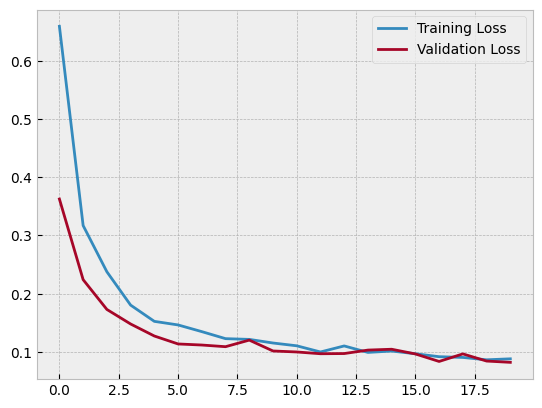

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.3680 - loss: 0.7468 - val_accuracy: 0.7500 - val_loss: 0.6175
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7891 - loss: 0.5764 - val_accuracy: 0.6000 - val_loss: 0.6001
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8383 - loss: 0.4570 - val_accuracy: 0.6000 - val_loss: 0.5977
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8242 - loss: 0.4059 - val_accuracy: 0.6000 - val_loss: 0.5940
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8086 - loss: 0.3741 - val_accuracy: 0.6500 - val_loss: 0.5843
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8453 - loss: 0.3670 - val_accuracy: 0.7000 - val_loss: 0.5790
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8609 - loss: 0.3279 - val_accuracy: 0.7500 - val_loss: 0.5716
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8555 - loss: 0.3224 - val

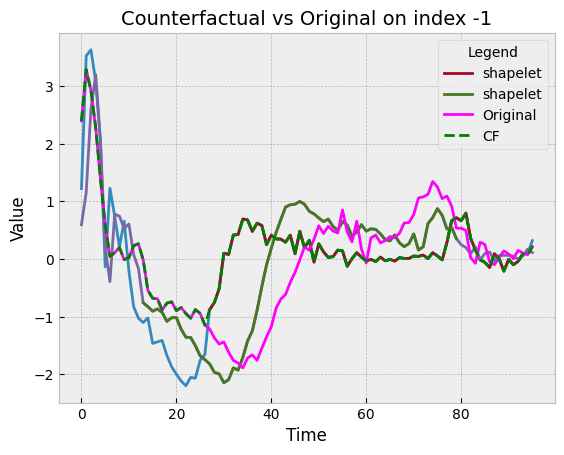

In [62]:
# Hauptfunktion zur Ausführung des Naive_Shapelet-Prozesses
def main():
    # Erstelle eine Instanz der Naive_Shapelet-Klasse
    naive_shapelet_instance = Naive_Shapelet()

    # Rufe save_res auf, um die Ergebnisse zu speichern
    naive_shapelet_instance.save_res()
    
    # Plotte den Vergleich von Original und Gegenbeispiel
    naive_shapelet_instance.plot_comparison_res(index=-1)

if __name__ == "__main__":
    main()

In [1]:
#Hier versuche ich die Dopplungen rauszukriegen mit train_model, aber da fehlt noch viel...
#siehe mehr hier: Train Model neue Version
class Naive_Shapelet:
    def __init__(self, method='naive_shapelet', DS_name='ECG200'):
        self.method = method
        self.DS_name = DS_name
        
        # Load the dataset
        self.X_train, self.X_test, self.y_train, self.y_test = read_data(DS=self.DS_name)
        
        # Adjust data shape
        if len(self.X_train.shape) == 2:
            self.X_train = np.expand_dims(self.X_train, axis=-1)
            self.X_test = np.expand_dims(self.X_test, axis=-1)
        
        # Build and train the autoencoder
        self.encoder, self.autoencoder = self.build_autoencoder()
        self.train_autoencoder()  # Train the autoencoder
        
        # Build the classifier (but don't train it yet)
        self.classifier = self.build_classifier()
        
        # Now train the classifier using the encoded data from the trained encoder
        self.train_classifier()

        # Display dataset information
        self.display_dataset_info()

    def build_autoencoder(self):
        input_shape = (self.X_train.shape[1], self.X_train.shape[2])

        # Encoder
        encoder_input = keras.Input(shape=input_shape)
        x = keras.layers.Conv1D(filters=16, kernel_size=5, strides=2, padding='same', activation='relu')(encoder_input)
        x = keras.layers.Dropout(rate=0.2)(x)
        x = keras.layers.Conv1D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
        x = keras.layers.Flatten()(x)
        encoder_output = keras.layers.Dense(50, activation='relu')(x)

        encoder = keras.Model(inputs=encoder_input, outputs=encoder_output, name="encoder")

        intermediate_shape = (input_shape[0] // 4, 8)

        # Decoder
        decoder_input = keras.Input(shape=(50,))
        x = keras.layers.Dense(np.prod(intermediate_shape), activation='relu')(decoder_input)
        x = keras.layers.Reshape(intermediate_shape)(x)
        x = keras.layers.Conv1DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
        x = keras.layers.Dropout(rate=0.2)(x)
        x = keras.layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, padding='same', activation='relu')(x)
        decoder_output = keras.layers.Conv1DTranspose(filters=input_shape[1], kernel_size=5, padding='same')(x)

        decoder = keras.Model(inputs=decoder_input, outputs=decoder_output, name="decoder")

        # Autoencoder model
        autoencoder_input = keras.Input(shape=input_shape)
        encoded = encoder(autoencoder_input)
        decoded = decoder(encoded)
        autoencoder = keras.Model(inputs=autoencoder_input, outputs=decoded, name="autoencoder")

        return encoder, autoencoder

    def train_autoencoder(self, epochs=20, batch_size=1):
        # Train the autoencoder using the training data
        history = self.autoencoder.fit(
            self.X_train,
            self.X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
        )

    def build_classifier(self):
        # Define the classifier architecture
        classifier = keras.Sequential([
            keras.layers.Input(shape=(50,)),  # Input shape matches the encoder's output
            keras.layers.Dense(100, activation='relu'),
            keras.layers.Dense(50, activation='relu'),
            keras.layers.Dense(len(np.unique(self.y_train)), activation='softmax')
        ])
        return classifier

    def train_classifier(self):
        """
        Trains the classifier using encoded training data from the trained encoder.
        """
        # Train the classifier using the train_model function
        self.classifier = self.train_model(
            self.encoder, 
            self.classifier, 
            self.X_train, 
            self.y_train, 
            self.X_test
        )

    def train_model(self, encoder, classifier, X_train, y_train, X_test, epochs=50, batch_size=32):
        """
        Trains the classifier using the encoded training data from the encoder.
        
        Parameters:
        encoder (keras.Model): The trained encoder model.
        classifier (keras.Model): The classifier model.
        X_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        X_test (numpy.ndarray): Test data.
        epochs (int): Number of epochs for training the classifier.
        batch_size (int): Batch size for training the classifier.
    
        Returns:
        classifier: The trained classifier.
        """
        # Encode the training data using the pre-trained encoder
        X_train_encoded = encoder.predict(X_train)
        
        # Train the classifier using the encoded training data
        classifier.fit(
            X_train_encoded,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
        )
    
        return classifier

    def display_dataset_info(self):
        # Display dataset statistics
        print(f"Dataset: {self.DS_name}")
        print(f"Shape of X_train: {self.X_train.shape}")
        print(f"Shape of y_train: {self.y_train.shape}")
        print(f"Shape of X_test: {self.X_test.shape}")
        print(f"Shape of y_test: {self.y_test.shape}")
        print(f"Number of classes: {len(np.unique(self.y_train))}")
        print(f"Unique class labels: {np.unique(self.y_train)}")

if __name__ == "__main__":
    naive_shapelet_instance = Naive_Shapelet()
    naive_shapelet_instance.save_res()
    naive_shapelet_instance.plot_comparison_res(index=-1)

NameError: name 'read_data' is not defined